## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
path = Path('./data/camvid-tiramisu')

In [5]:
path.ls()

[PosixPath('data/camvid-tiramisu/val.txt'),
 PosixPath('data/camvid-tiramisu/valannot'),
 PosixPath('data/camvid-tiramisu/testannot'),
 PosixPath('data/camvid-tiramisu/trainannot'),
 PosixPath('data/camvid-tiramisu/test'),
 PosixPath('data/camvid-tiramisu/test.txt'),
 PosixPath('data/camvid-tiramisu/train'),
 PosixPath('data/camvid-tiramisu/val'),
 PosixPath('data/camvid-tiramisu/train.txt')]

## Data

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('data/camvid-tiramisu/val/0016E5_08151.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_08003.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_07975.png')]

In [7]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('data/camvid-tiramisu/valannot/0016E5_08151.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_08003.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_07975.png')]

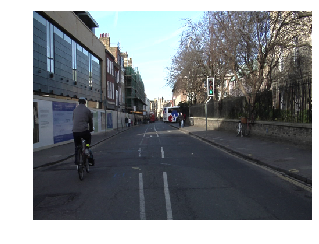

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

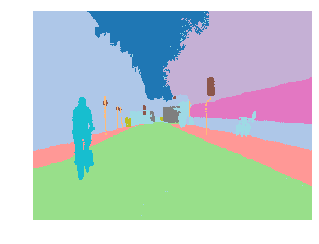

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [12]:
bs = 8

In [13]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

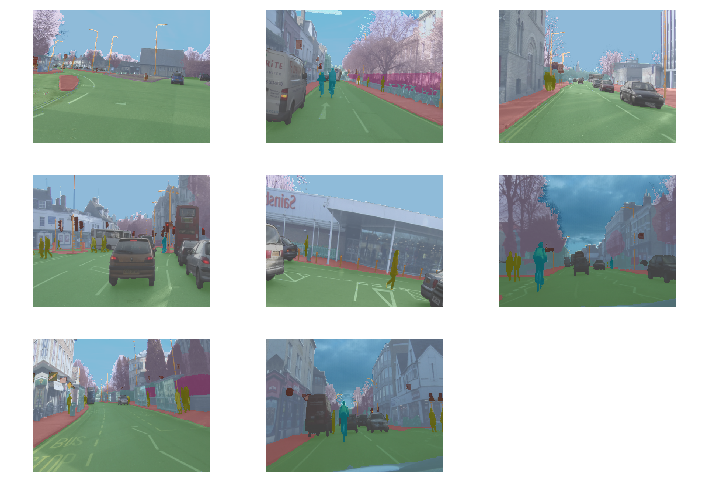

In [15]:
data.show_batch(4, figsize=(10,7))

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


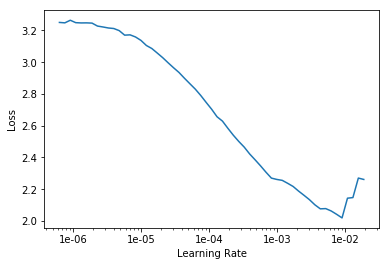

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
lr=2e-3

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.480240,0.508797,0.863724,00:31
1,0.465781,0.471159,0.868394,00:32
2,0.441798,0.423472,0.873687,00:32
3,0.425886,0.400853,0.881981,00:32
4,0.416932,0.374856,0.902488,00:32
5,0.390167,0.336166,0.897149,00:32
6,0.378081,0.383295,0.895792,00:32
7,0.381068,0.325110,0.899495,00:32
8,0.350711,0.274659,0.911363,00:32
9,0.310631,0.270535,0.916623,00:32


In [26]:
learn.save('stage-1')

In [27]:
learn.load('stage-1');

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/100,lr)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.277389,0.270462,0.915004,00:34
1,0.270546,0.253759,0.920805,00:34
2,0.268121,0.280855,0.913263,00:33
3,0.265078,0.288246,0.912440,00:33
4,0.269419,0.276713,0.920848,00:33
5,0.266702,0.258561,0.925775,00:34
6,0.269936,0.373994,0.899984,00:34
7,0.283414,0.297340,0.917312,00:33
8,0.280057,0.315092,0.915224,00:33
9,0.262692,0.259886,0.925030,00:33


In [31]:
learn.save('stage-2');

## Go big

In [32]:
learn=None
gc.collect()

22

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [33]:
size = src_size
bs=8

In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


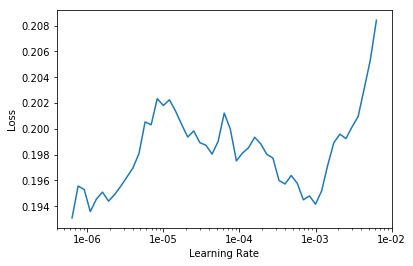

In [36]:
lr_find(learn)
learn.recorder.plot()

In [37]:
lr=1e-3

In [38]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.194831,0.250438,0.929078,00:32
1,0.193264,0.244537,0.931031,00:32
2,0.191694,0.246486,0.929981,00:32
3,0.189681,0.266352,0.927318,00:32
4,0.189788,0.244744,0.930028,00:32
5,0.189750,0.251552,0.929096,00:32
6,0.188403,0.285295,0.925308,00:32
7,0.191650,0.290140,0.928613,00:32
8,0.186786,0.255509,0.930334,00:32
9,0.175638,0.250901,0.933334,00:32


In [39]:
learn.save('stage-1-big')

In [40]:
learn.load('stage-1-big');

In [41]:
learn.unfreeze()

In [42]:
lrs = slice(lr/1000,lr/10)

In [43]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.162774,0.251746,0.933699,00:33
1,0.165559,0.250499,0.933027,00:33
2,0.161077,0.249499,0.932847,00:33
3,0.160372,0.253255,0.932574,00:33
4,0.160214,0.253750,0.931901,00:33
5,0.159633,0.246612,0.934379,00:33
6,0.158308,0.263429,0.931419,00:33
7,0.157202,0.260111,0.932176,00:33
8,0.155742,0.257196,0.932445,00:34
9,0.154123,0.260645,0.931781,00:33


In [44]:
learn.save('stage-2-big')

In [45]:
learn.load('stage-2-big');

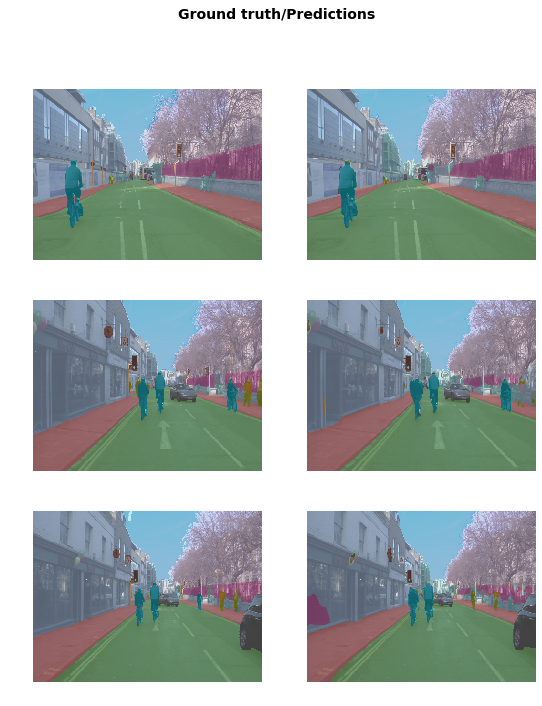

In [46]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [47]:
# start: 480x360

In [48]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________